In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats
from sbi.utils.get_nn_models import posterior_nn
import pickle
from getdist import plots
from getdist import MCSamples

%matplotlib inline


#path_to_file = 'path/to/cosmoped'
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

file_path = '/Users/aisulu/Desktop/report_code/noise_fake_planck_realistic_two.dat'

try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1]

2024-04-28 00:51:57.904782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path='/Users/aisulu/Desktop/report_code/LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

In [3]:
data = np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-24_10000__1.txt')
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_10000__1.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__3.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__4.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_30000__1.txt')),axis=0)

data_reshape = []
for i in range(len(data)):
    sample = [data[i][2]-0.032-3e-3-0.0105+0.00920, (data[i][3]-0.075)/100, data[i][4]+0.011-5.775e-3+4e-3-8.25e-4, 
              np.log(10*data[i][5])-0.113-0.0175+0.0116-0.000526, data[i][6]+2e-3-0.0015]
    data_reshape.append(sample)
data_reshape = np.array(data_reshape)

In [4]:
def simulator(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

def noise(sim):
    cat = np.array(sim['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(sim['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2500]}

In [5]:
obs2=deepcopy(obs)
for i in range(49):
    l=i+2
    nm=np.round(fsky*(2*l+1))
    obs2['TT'][i]*=((nm-1)/(nm-2))**-0.5
cltt = obs2['TT']
output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
obs_compressed = torch.tensor(output)

In [6]:
cltt = noise(obs)['TT']
output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
obs_compressed2 = torch.tensor(output)

In [7]:
cltt = obs['TT']
output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
obs_compressed3 = torch.tensor(output)

In [ ]:
x = np.load('sims_pars_saved/sims/trunc_r1.npy')
theta = np.load('sims_pars_saved/pars/trunc_r1.npy')
low = [0.6340, 0.0213, 0.1079, 3.0499, 0.9389]
high = [0.7282, 0.0234, 0.1308, 3.0962, 0.9978]

prior = utils.BoxUniform(low=torch.as_tensor(low),
                         high=torch.as_tensor(high))

inference = SNPE(prior=prior)

inference = inference.append_simulations(torch.tensor(theta, dtype = torch.float32), 
                                         torch.tensor(x, dtype = torch.float32))

density_estimator = inference.train(training_batch_size=128, learning_rate=1e-4)

In [8]:
param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']
def plot_corner(samples_list, sbi_pack = True):
    param_names = ["param1", "param2", 'param3', 'param4', 'param5']
    param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']
    mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
    if sbi_pack == True:
        sbi_samples = MCSamples(samples=samples_list.numpy(), names=param_names, labels=param_labels)
    else:
        sbi_samples = MCSamples(samples=samples_list, names=param_names, labels=param_labels)
    g = plots.get_subplot_plotter()
    g.settings.figure_legend_frame = False
    g.triangle_plot([ sbi_samples, mcmc_samples], filled=True, contour_colors = ['cyan', 'green', 'red'],
                    legend_labels=['Result', ' MCMC'],
                    markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                              'color': 'black'}, 
                              title_limit = 1
                );

In [ ]:
posterior = inference.build_posterior(density_estimator)
posterior.set_default_x(obs_compressed2)
posterior_samples = posterior.sample((100000,))

posterior2 = inference.build_posterior(density_estimator)
posterior2.set_default_x(obs_compressed3)
posterior_samples2 = posterior2.sample((1000000,))

In [ ]:
plot_corner(posterior_samples)

In [9]:
def find_all(getdist_samples):
    mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
    p = getdist_samples.getParams()
    p2 = mcmc_samples.getParams()

    params_sbi = [p.param1, p.param2,p.param3,p.param4,p.param5]
    params_mcmc = [p2.param1, p2.param2,p2.param3,p2.param4,p2.param5]

    mean_sbi = []
    err_sbi = []
    limits_sbi = []

    mean_mcmc = []
    err_mcmc = []
    limits_mcmc = []

    for i in range(5):
        mean_sbi_i = getdist_samples.mean(params_sbi[i])
        err_sbi_i = getdist_samples.std(params_sbi[i])
        limits_sbi_i = getdist_samples.twoTailLimits(params_sbi[i],0.95)
        mean_sbi.append(mean_sbi_i)
        err_sbi.append(err_sbi_i)
        limits_sbi.append(limits_sbi_i)

        mean_mcmc_i = mcmc_samples.mean(params_mcmc[i])
        err_mcmc_i = mcmc_samples.std(params_mcmc[i])
        limits_mcmc_i = mcmc_samples.twoTailLimits(params_mcmc[i],0.95)
        mean_mcmc.append(mean_mcmc_i)
        err_mcmc.append(err_mcmc_i)
        limits_mcmc.append(limits_mcmc_i)

    mean_sbi = np.array(mean_sbi)
    err_sbi = np.array(err_sbi)
    limits_sbi = np.array(limits_sbi)
    mean_mcmc = np.array(mean_mcmc)
    err_mcmc = np.array(err_mcmc)
    limits_mcmc = np.array(limits_mcmc)

    return mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc

In [ ]:
mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc = find_all(MCSamples(samples=posterior_samples.numpy(), names=param_names, labels=param_labels))

In [ ]:
print("shift: MCMC - SAMPLES:")
for i in range(5):
    print(mean_mcmc[i]-mean_sbi[i])

In [ ]:
from tqdm import tqdm 
posterior_samples_shift = []
posterior_samples_np = np.array(posterior_samples)
for i in tqdm(range(len(posterior_samples))):
    samples_shifted = [posterior_samples_np[i][0], 
                       posterior_samples_np[i][1]-0.0004914,
                       posterior_samples_np[i][2]-0.002564,
                       posterior_samples_np[i][3]+0.00907,
                       posterior_samples_np[i][4]+0.00481388]
    posterior_samples_shift.append(samples_shifted)



In [ ]:
posterior_samples_shift = np.array(posterior_samples_shift)

In [ ]:
print(posterior_samples_shift[0])
print(posterior_samples[0])

In [ ]:
plot_corner(posterior_samples_shift, sbi_pack = False)

In [ ]:
quant = 0.0
lower_quantile = torch.quantile(posterior_samples, torch.tensor(quant), dim=0)
upper_quantile = torch.quantile(posterior_samples, torch.tensor(1 - quant), dim=0)
print(lower_quantile)
print(upper_quantile)

In [ ]:
with open('posteriors_good/posterior_truncated_prior_with_bank.pkl', 'wb') as file:
    pickle.dump(posterior, file)

In [ ]:
np.save('posterior_samples/samples_truncated_prior_with_bank.npy', posterior_samples_shift)

In [ ]:
def snpe_sim(params):
    sim = simulator(np.array(params))
    noise_sim = noise(sim)['TT']
    compressed = [compress_vec_h.dot(noise_sim), compress_vec_ombh2.dot(noise_sim), compress_vec_omch2.dot(noise_sim), compress_vec_As.dot(noise_sim),compress_vec_ns.dot(noise_sim)]
    return noise_sim, compressed

In [ ]:
inference = SNPE(prior=prior)

with open('/Users/aisulu/Desktop/report_code/samples/samples_10000_sim_wishart.pkl', 'rb') as file:
    sim_wishart = pickle.load(file)

x = np.load('sims_pars_saved/sims/trunc_r1.npy')
theta = np.load('sims_pars_saved/pars/trunc_r1.npy')

inference = inference.append_simulations(torch.tensor(theta, dtype = torch.float32), 
                                         torch.tensor(x, dtype = torch.float32))

density_estimator = inference.train(training_batch_size=128, learning_rate = 1e-3)

posterior = inference.build_posterior(density_estimator)
posterior.set_default_x(obs_compressed2)
posterior_samples = posterior.sample((100000,))

posterior2 = inference.build_posterior(density_estimator)
posterior2.set_default_x(obs_compressed3)
posterior_samples2 = posterior2.sample((100000,))

plot_corner(posterior_samples)
plot_corner(posterior_samples2)

In [ ]:
mean_sbi, err_sbi, limits_sbi, mean_mcmc, err_mcmc, limits_mcmc = find_all(MCSamples(samples=posterior_samples.numpy(), names=param_names, labels=param_labels))
print("shift: MCMC - SAMPLES:")
for i in range(5):
    print(mean_mcmc[i]-mean_sbi[i])

In [ ]:
posterior_samples_shift = []
posterior_samples_np = np.array(posterior_samples)
for i in tqdm(range(len(posterior_samples))):
    samples_shifted = [posterior_samples_np[i][0]-0.007055, 
                       posterior_samples_np[i][1]-0.000654,
                       posterior_samples_np[i][2]-0.0008349,
                       posterior_samples_np[i][3]+0.0116560,
                       posterior_samples_np[i][4]-0.00011]
    posterior_samples_shift.append(samples_shifted)
posterior_samples_shift = np.array(posterior_samples_shift)

In [ ]:
plot_corner(posterior_samples_shift, sbi_pack = False)

In [ ]:
np.save('posterior_samples/samples_trucnated_prior_w_bank_v2.npy', posterior_samples_shift)

with open('posteriors_good/posterior_truncated_prior_with_bank_v2.pkl', 'wb') as file:
    pickle.dump(posterior, file)

In [ ]:

from sbi.analysis.plot import sbc_rank_plot
from sbi.analysis import check_sbc, run_sbc

def snpe_sim(params):
    sim = simulator(np.array(params))
    noise_sim = noise(sim)['TT']
    compressed = [compress_vec_h.dot(noise_sim), compress_vec_ombh2.dot(noise_sim), compress_vec_omch2.dot(noise_sim), compress_vec_As.dot(noise_sim),compress_vec_ns.dot(noise_sim)]
    return torch.tensor(compressed)

num_simulations = 200  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
#thetas = prior.sample((num_simulations,))
#xs = snpe_sim(thetas)

num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    torch.tensor(theta[:1000]), torch.tensor(x[:1000]), posterior, num_posterior_samples=num_posterior_samples
)



In [ ]:

check_stats = check_sbc(
    ranks, torch.tensor(theta[:1000]), dap_samples, num_posterior_samples=num_posterior_samples
)

In [ ]:

print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

In [ ]:


f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

In [ ]:
ranks, dap_samples = run_sbc(torch.tensor(theta[:1000]), torch.tensor(x[:1000]),
    posterior,
    num_posterior_samples=num_posterior_samples,
    reduce_fns=posterior.log_prob,
)
check_stats = check_sbc(ranks, torch.tensor(theta[:1000]), dap_samples, 1_000)
print(check_stats)

In [43]:
c2st = [0.4865, 0.5240, 0.5180, 0.5255, 0.4985] #for not truncated posterior
c2st_tr = [0.5165, 0.5025, 0.4965, 0.5045, 0.4865] #for first truncation
c2st_tr_f = [0.5185, 0.5275, 0.5175, 0.5165, 0.5340] #last round truncation

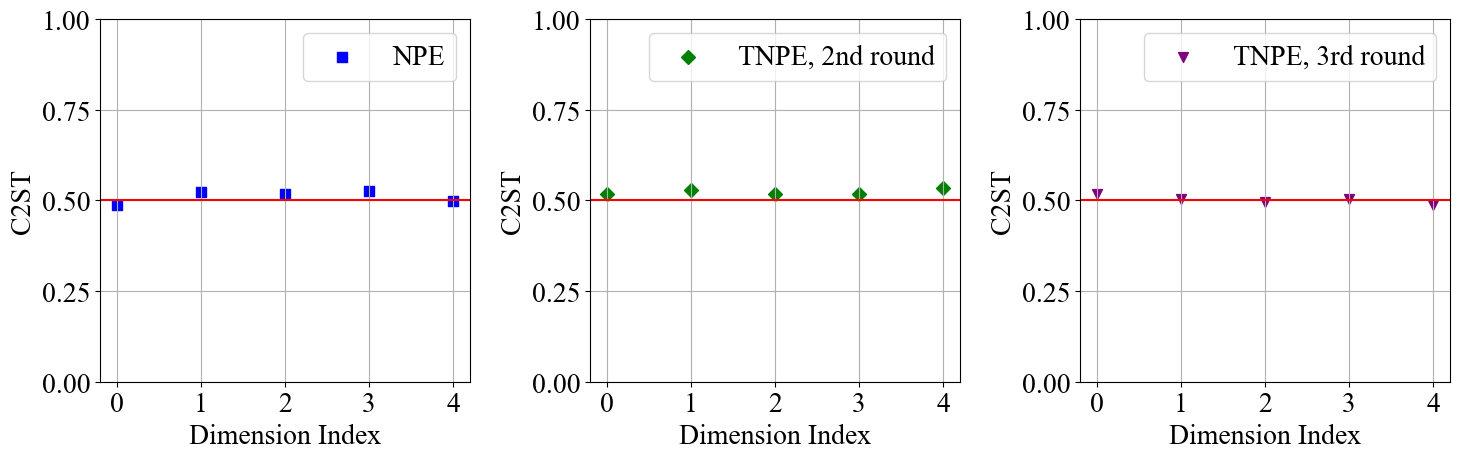

In [59]:
dims = np.arange(5)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20


fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].scatter(dims, c2st, 50,  marker = 's', color = 'blue', label = 'NPE')
axes[2].scatter(dims, c2st_tr, 50,  marker = 'v', color = 'purple', label = 'TNPE, 3rd round')
axes[1].scatter(dims, c2st_tr_f, 50,  marker = 'D', color = 'green', label = 'TNPE, 2nd round')

for i in range(3):
    axes[i].axhline(0.5, color = 'red')
    axes[i].set_ylim([0.0, 1.0])
    axes[i].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    axes[i].set_xticks([0, 1, 2, 3, 4])
    axes[i].set_ylabel('C2ST')
    axes[i].set_xlabel('Dimension Index')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()

plt.savefig('c2st_test.pdf')



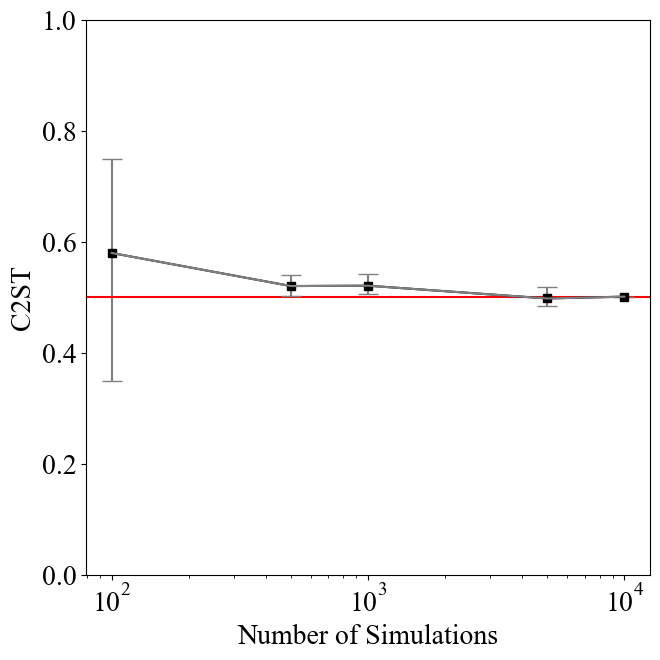

In [95]:
c2st_100 = [0.3500, 0.6000, 0.7500, 0.6500, 0.5500]
c2st_100_av = np.average(c2st_100)
c2st_500 = [0.5095, 0.5325, 0.5175, 0.5400, 0.5025]
c2st_500_av = np.average(c2st_500)
c2st_1000 = [0.5417, 0.5067, 0.5100, 0.5250, 0.5217]
c2st_1000_av = np.average(c2st_1000)
c2st_5000 = [0.4750, 0.4833, 0.5133, 0.4617, 0.5567]
c2st_5000_av = np.average(c2st_5000)

c2st_10000_av = np.average(c2st_tr)

errors = [[c2st_100_av - min(c2st_100), c2st_500_av - min(c2st_500), c2st_1000_av - min(c2st_1000), c2st_1000_av - min(c2st_1000), 0],
          [max(c2st_100) - c2st_100_av, max(c2st_500) - c2st_500_av, max(c2st_1000) - c2st_1000_av,  max(c2st_1000) - c2st_1000_av, 0]]


plt.figure(figsize = (7, 7))
plt.axhline(0.5, color = 'red')
plt.errorbar([100, 500, 1000, 5000, 10000], [c2st_100_av,c2st_500_av,c2st_1000_av, c2st_5000_av, c2st_10000_av  ], yerr = errors, capsize=7, color = 'grey')
plt.plot([100, 500, 1000, 5000, 10000], [c2st_100_av,c2st_500_av,c2st_1000_av, c2st_5000_av, c2st_10000_av  ], color = 'black', marker = 's')
plt.ylim ([0.0, 1.0])
plt.xticks([100, 500, 1000, 5000, 10000])
plt.xscale('log')
plt.xlabel('Number of Simulations')
plt.ylabel('C2ST')
plt.tight_layout()

plt.savefig('simulation_cost_c2st.pdf')


## For plotting

In [12]:
import healpy

def add_noise_healpy(cls):
    true_cls = np.insert(cls, [0, 0], 0)
    alms = hp.sphtfunc.synalm(true_cls, lmax=2500)
    clhats = hp.sphtfunc.alm2cl(alms, lmax=2500)[2:]
    return clhats*ells

dl_bank = np.load('/Users/aisulu/Desktop/gcloud_files/cls.npy')
pars_bank = np.load('/Users/aisulu/Desktop/report_code/params.npy')

In [15]:
from tqdm import tqdm
mins = np.array([50, 0.01, 0.01, 1.5, 0.8])
maxs = np.array([90, 0.05, 0.5, 3.5, 1])

prior = utils.BoxUniform(low=torch.as_tensor(mins),
                         high=torch.as_tensor(maxs))

inference2 = SNPE(prior=prior)

def compress(dl_hats):
    cltt = dl_hats[:2499]/ells
    compressed = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return compressed

dl_comp = [compress(dl_bank[i]) for i in tqdm(range(len(dl_bank)))]

inference2 = inference2.append_simulations(torch.tensor(pars_bank, dtype = torch.float32), 
                                         torch.tensor(dl_comp, dtype = torch.float32))

density_estimator2 = inference2.train()

posterior_bank2 = inference2.build_posterior(density_estimator2)
posterior_bank2.set_default_x(obs_compressed)
posterior_bank2_samples = posterior_bank2.sample((100000,))

plot_corner(posterior_bank2_samples)

  5%|▍         | 3918/80030 [00:00<00:01, 39167.52it/s]

100%|██████████| 80030/80030 [00:02<00:00, 31156.29it/s]


 Neural network successfully converged after 196 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    100000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


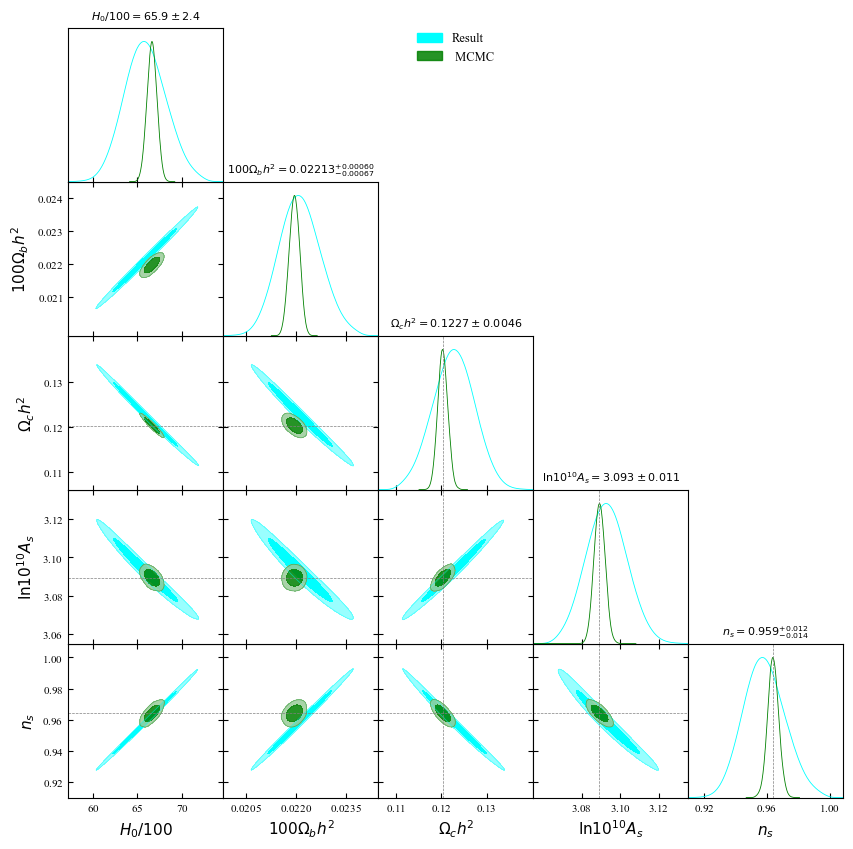

In [17]:
def simulator_nonltt(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
obs_uncompress = torch.tensor(compress(simulator_nonltt(pl)['TT']*ells))

posterior_bank2 = inference2.build_posterior(density_estimator2)
posterior_bank2.set_default_x(obs_uncompress)
posterior_bank2_samples = posterior_bank2.sample((100000,))

data = np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-24_10000__1.txt')
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_10000__1.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__3.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__4.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_30000__1.txt')),axis=0)

data_reshape = []
for i in range(len(data)):
    sample = [(data[i][2]-0.032-3e-3-0.0105+0.00920)*100, (data[i][3]-0.075)/100, data[i][4]+0.011-5.775e-3+4e-3-8.25e-4, 
              np.log(10*data[i][5])-0.113-0.0175+0.0116-0.000526, data[i][6]+2e-3-0.0015]
    data_reshape.append(sample)
data_reshape = np.array(data_reshape)

plot_corner(posterior_bank2_samples)

In [21]:
inference2 = SNPE(prior=prior)
inference2 = inference2.append_simulations(torch.tensor(pars_bank, dtype = torch.float32), 
                                         torch.tensor(dl_comp, dtype = torch.float32))

density_estimator2 = inference2.train(learning_rate = 1e-5, training_batch_size=128)

posterior_bank2 = inference2.build_posterior(density_estimator2)
posterior_bank2.set_default_x(obs_uncompress)
posterior_bank2_samples = posterior_bank2.sample((100000,))

plot_corner(posterior_bank2_samples)

 Training neural network. Epochs trained: 334

KeyboardInterrupt: 